In [11]:
library(tidyverse)
library(tidymodels)
library(repr)
library(ggplot2)

In [2]:
players_url <- "https://raw.githubusercontent.com/604Beast/Project-Planning-Stage/refs/heads/main/players.csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players_clean <- players |>
                select(subscribe,played_hours, Age) |> 
                mutate(subscribe = as.factor(subscribe)) 
                

In [4]:
players_split <- initial_split(players_clean, prop = 0.70, strata = subscribe)  
players_training <- training(players_split)
players_testing <-testing(players_split)

head(players_training)
nrow(players_training) # might not be good enough to train classifier 
nrow(players_testing) 

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,17
FALSE,0.0,22
FALSE,0.1,17
FALSE,0.0,23
FALSE,0.1,18
FALSE,0.0,33


[1] 136

[1] 60

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


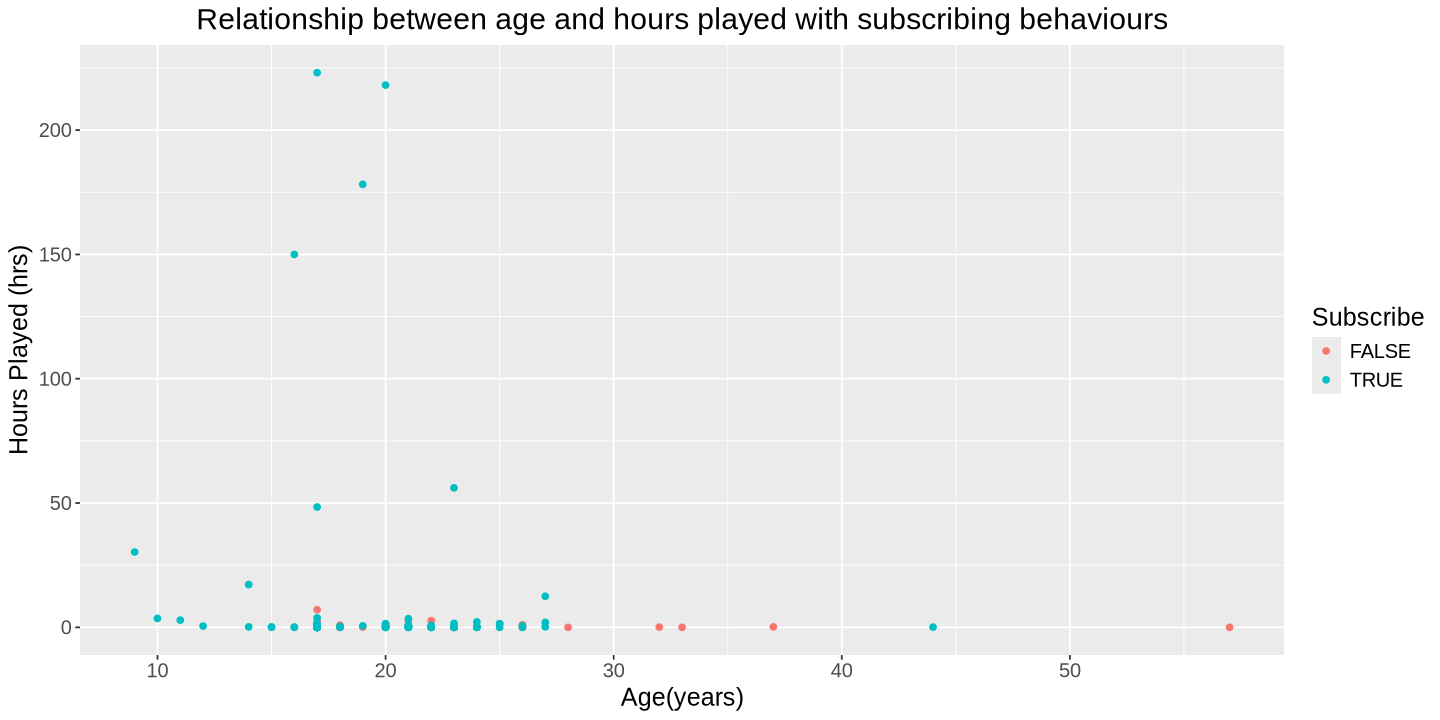

In [5]:
options(repr.plot.width = 12, repr.plot.height = 6)  
players_plot <-ggplot(players_training, aes( x = Age, y = played_hours, 
                                            color = subscribe))+
                    geom_point()+
                    ggtitle("Relationship between age and hours played with subscribing behaviours") + 
                    labs( x = "Age(years)", y = "Hours Played (hrs)", color = "Subscribe")+ 
                    theme(text = element_text(size = 15)) +
                    theme(plot.title = element_text(hjust =0.5))
players_plot

In [22]:
set.seed(1)
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training)|> 
                step_scale(all_predictors()) |>
                step_center(all_predictors())

players_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
            set_engine("kknn")|>
            set_mode("classification") 

players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = c(1:50))

players_results <-workflow() |>
                add_recipe(players_recipe)|>
                add_model(players_tune) |>
                tune_grid(resamples = players_vfold, grid = k_vals)|>
                collect_metrics()|>
                filter(.metric == "accuracy")|>
                select(neighbors, mean) |>
                arrange(desc(mean))

head(players_results)

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 26 rows.
               ✖ Assigned data has 27 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 27 to size 26.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x2





neighbors,mean
<int>,<dbl>
21,0.7442681
22,0.7442681
19,0.7319224
20,0.7319224
23,0.7319224
24,0.7319224


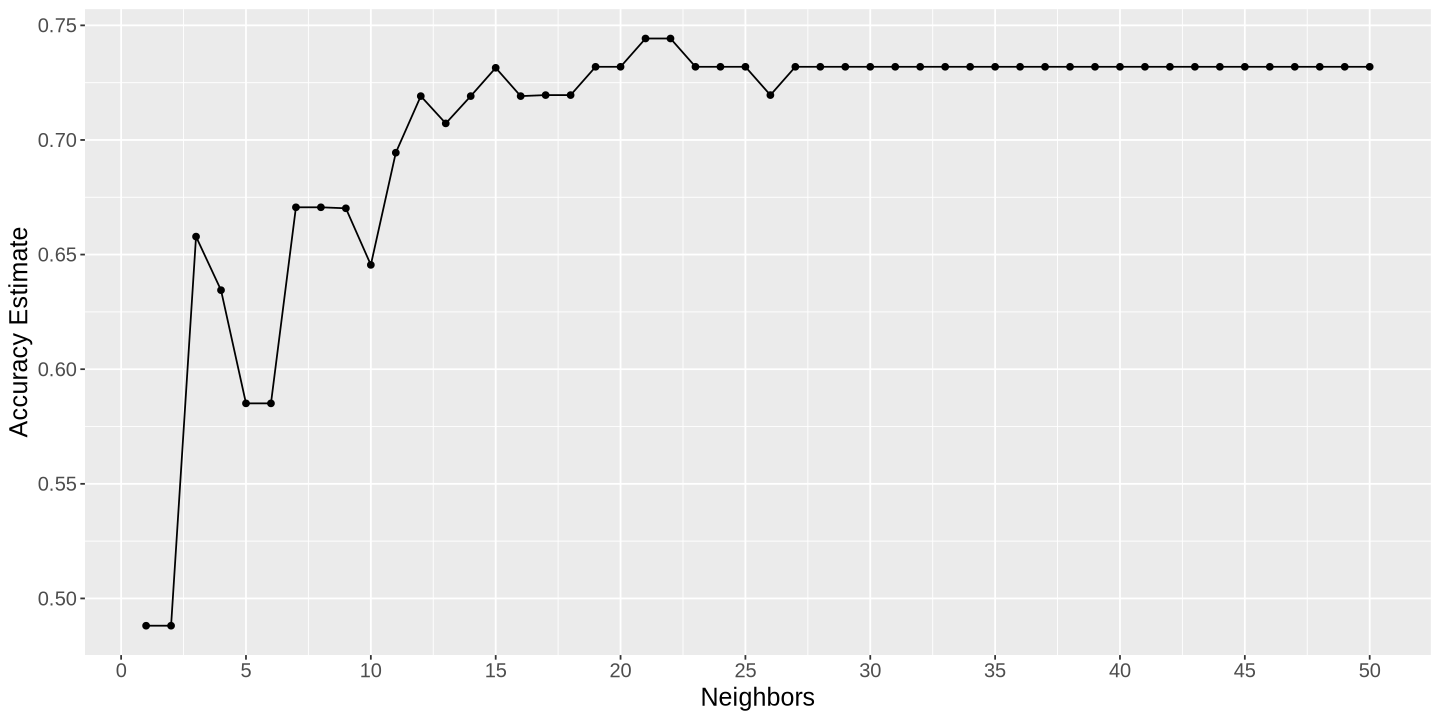

In [23]:
accuracy_vs_k <- ggplot(players_results, aes(x = neighbors, y = mean))+ 
                geom_point()+ 
                geom_line()+ 
                labs( x = "Neighbors", y = "Accuracy Estimate") + 
                scale_x_continuous(breaks = seq(0,100, by = 5)) + 
                theme(text = element_text(size = 15))
accuracy_vs_k